In [1]:
from scipy.spatial import distance_matrix
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np
import torch

In [2]:
from SearchingOptimalEnsembles.metadatasets.ftc.metadataset import FTCMetaDataset
from SearchingOptimalEnsembles.metadatasets.ftc.hub import MODELS
from SearchingOptimalEnsembles.posthoc.neural_ensembler import NeuralEnsembler


/home/pineda/anaconda3/envs/searching_optimal_ensembles/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/pineda/anaconda3/envs/searching_optimal_ensembles/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
metadataset_mini = FTCMetaDataset( metric_name="error",
                                data_version="mini")
metadataset_extended = FTCMetaDataset( metric_name="error",
                        data_version="extended")  

def preprocess(X):
    X = pd.DataFrame(X)
    ohe = OneHotEncoder(handle_unknown='ignore', categories=[MODELS])
    X_model = ohe.fit_transform(X[["model"]].values).todense()
    X = np.concatenate([X[["lora_r", "learning_rate"]], X_model], axis=-1)
    return X

In [4]:
metadataset_mini.dataset_names

['imdb',
 'mteb/tweet_sentiment_extraction',
 'ag_news',
 'dbpedia_14',
 'stanfordnlp/sst2',
 'SetFit/mnli']

In [5]:
dataset_name = 'ag_news'
metadataset_mini.set_state(dataset_name=dataset_name, split="valid")
metadataset_extended.set_state(dataset_name=dataset_name, split="valid")



In [7]:
hp_mini = metadataset_mini.row_hp_candidates[dataset_name]
hp_extended = metadataset_extended.row_hp_candidates[dataset_name]

hp_mini = preprocess(hp_mini)
hp_extended = preprocess(hp_extended)

    
a = distance_matrix(hp_mini, hp_extended)
from_mini_to_extended = a.argmin(-1)[a.min(-1)==0]
from_extended_to_mini = a.argmin(0)[a.min(0)==0]

In [8]:
ne = NeuralEnsembler(metadataset=metadataset_mini,
                        metric_name="error",
                        ne_net_mode="model_averaging",
                        ne_net_type="simple")
X_obs_extended = np.arange(len(hp_extended))
X_obs_mini = from_extended_to_mini[X_obs_extended]
ne.sample(X_obs_mini)

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/metadatasets/ftc/metadataset.py:207: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  pred = torch.nn.Softmax(dim=-1)(pred[torch.LongTensor(ensembles)])
/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:410: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 0.5150349140167236
Epoch 1 Loss 0.5237256288528442
Epoch 2 Loss 0.5132184624671936
Epoch 3 Loss 0.5245577096939087
Epoch 4 Loss 0.4983883202075958
Epoch 5 Loss 0.5244656801223755
Epoch 6 Loss 0.5192304253578186
Epoch 7 Loss 0.5134216547012329
Epoch 8 Loss 0.5147769451141357
Epoch 9 Loss 0.523858368396759
Epoch 10 Loss 0.5046272277832031
Epoch 11 Loss 0.5157670378684998
Epoch 12 Loss 0.5067747235298157
Epoch 13 Loss 0.5091896653175354
Epoch 14 Loss 0.5009710192680359
Epoch 15 Loss 0.5096142888069153
Epoch 16 Loss 0.5180611610412598
Epoch 17 Loss 0.508921205997467
Epoch 18 Loss 0.4980504512786865
Epoch 19 Loss 0.5171364545822144
Epoch 20 Loss 0.5158013701438904
Epoch 21 Loss 0.5147070288658142
Epoch 22 Loss 0.4977547824382782
Epoch 23 Loss 0.5199030041694641
Epoch 24 Loss 0.5030564069747925
Epoch 25 Loss 0.519619345664978
Epoch 26 Loss 0.5046210885047913
Epoch 27 Loss 0.5074107646942139
Epoch 28 Loss 0.5166508555412292
Epoch 29 Loss 0.5151249170303345
Epoch 30 Loss 0.5151373

(None, tensor(0.0690))

In [9]:
metadataset_mini.set_state(dataset_name=dataset_name,
                           split="test")
metadataset_extended.set_state(dataset_name=dataset_name,
                           split="test")
transferred_weights = ne.get_weights(X_obs_mini)[0]
predictions = metadataset_extended.get_predictions([X_obs_extended])[0]
target = metadataset_extended.get_targets()
ensemble_pred = torch.mul(predictions,transferred_weights).sum(0)
metadataset_extended.score_y_pred(ensemble_pred, target)

In [35]:
metadataset_extended.set_state(dataset_name=dataset_name,
                           split="valid")
ne = NeuralEnsembler(metadataset=metadataset_extended,
                        metric_name="error",
                        ne_net_mode="model_averaging",
                        ne_net_type="ffn")
ne.sample(X_obs_extended)
metadataset_extended.set_state(dataset_name=dataset_name,
                           split="test")
weights = ne.get_weights(X_obs_extended)[0]
ensemble_pred = torch.mul(predictions,weights).sum(0)
metadataset_extended.score_y_pred(ensemble_pred, target)

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:410: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 0.49675244092941284
Epoch 1 Loss 0.4901706278324127
Epoch 2 Loss 0.49558162689208984
Epoch 3 Loss 0.48880404233932495
Epoch 4 Loss 0.49915456771850586
Epoch 5 Loss 0.4992790222167969
Epoch 6 Loss 0.49466222524642944
Epoch 7 Loss 0.5009112358093262
Epoch 8 Loss 0.5028119087219238
Epoch 9 Loss 0.49992913007736206
Epoch 10 Loss 0.4928842782974243
Epoch 11 Loss 0.4927738904953003
Epoch 12 Loss 0.49765825271606445
Epoch 13 Loss 0.49949008226394653
Epoch 14 Loss 0.4954439401626587
Epoch 15 Loss 0.49594593048095703
Epoch 16 Loss 0.5096141695976257
Epoch 17 Loss 0.4950292408466339
Epoch 18 Loss 0.5052633285522461
Epoch 19 Loss 0.49195602536201477
Epoch 20 Loss 0.49048274755477905
Epoch 21 Loss 0.49140095710754395
Epoch 22 Loss 0.49243783950805664
Epoch 23 Loss 0.4986109733581543
Epoch 24 Loss 0.5018967986106873
Epoch 25 Loss 0.49492669105529785
Epoch 26 Loss 0.4867711365222931
Epoch 27 Loss 0.4922376573085785
Epoch 28 Loss 0.5005565285682678
Epoch 29 Loss 0.48973754048347473
Epoch

tensor(0.0467)

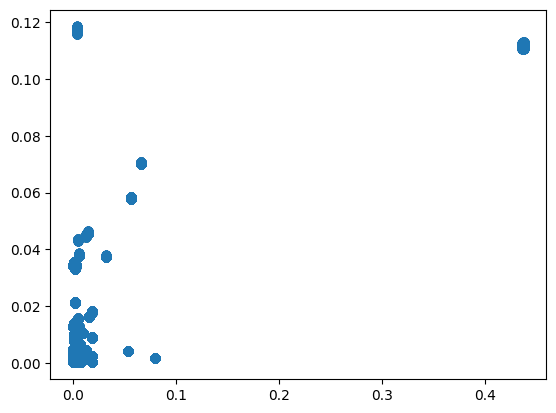

In [36]:
import matplotlib.pyplot as plt
plt.scatter(weights.numpy(), transferred_weights.numpy())